In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

In [2]:
languages = !ls 'wiki_data/processed/'
languages

['bulgarian(ru).txt',
 'croatian(hr).txt',
 'czech(cs).txt',
 'danish(da).txt',
 'dutch(en).txt',
 'english(en).txt',
 'french(fr).txt',
 'german(de).txt',
 'italian(it).txt',
 'norwegian(da).txt',
 'polish(pl).txt',
 'romanian(ro).txt',
 'serbian(sr).txt',
 'spanish(es).txt',
 'swedish(sv).txt']

Имеем 15 европейских языков в качестве входного алфавита. Запишем их в словарь для дальнейшей удобной работы

In [72]:
%%time
lang_texts = {}

for lang in languages:
    lang_name = lang[:-8]
    with open('wiki_data/processed/' + lang, 'r') as processed_file:
        text = processed_file.read().replace('\n', '').decode('utf-8')
    lang_texts[lang_name] = text

CPU times: user 9.54 s, sys: 7.19 s, total: 16.7 s
Wall time: 19.1 s


In [73]:
print lang_texts['serbian'][:100]

ппјвнппјвнлтнскмрдцмбрјбппддцмбргдндсвјсмртсмтрсзјднгднјспсбнјхппвквлкдсвгпнтфктјвнјпрвбрбсмслмнскмс


In [74]:
# средняя длина текстов
int(np.mean([len(x) for x in lang_texts.values()]))

213124602

У нас в наличии выборка из 15 европейских языков, общая длина текстов каждого языка в среднем 213 миллионов знаков. Из [Предыдущего исследования](Voynich Language Detection.ipynb) видим, что 30000 символов достаточно, чтобы с точностью около 95% определять язык текста. В этом ноутбуке попробуем пойти другим путем. Разобъем наши тексты на фрагменты по `K` символов (дальше выясним, какое `K` является оптимальным для хорошего качества предсказания) и обучим классификатор на векторах N-грам этих фрагментов. Предполагаемый способ может дать возможность определять язык даже для маленьких фрагментов текста (до 100 символов) с большой точностью, а также получится выделить из языков некоторые N-грамы, которые хорошо их описывают.

### Part I: Different alphabets 

Первым делом проверим способ на данных с полным алфавитам, каждый текст рассматривается в том алфавите, в котором изначально написан. В следующем разделе будем проверять гипотезу для текстов, перекодированных в латиницу. Это может приблизить нас к задаче с Манускриптом Войнича.

In [12]:
def get_text_frames(text, samples_number, frame_len):
    frames = []
    for i in xrange(samples_number):
        cur_index = i * frame_len
        frames.append(text[cur_index:(cur_index + frame_len)])
    return frames

def generate_text_subsamples (lang_samples_num = 5000, frame_len = 100):

    data = pd.DataFrame(columns=['frame', 'lang'])

    for lang in lang_texts:
        frames = get_text_frames(lang_texts[lang], lang_samples_num, frame_len)
        langs = [lang for _ in range(lang_samples_num)]
        data = pd.concat([data, pd.DataFrame({'frame': frames, 'lang': langs})], ignore_index=True)

    return data

In [75]:
%%time
data = generate_text_subsamples()

CPU times: user 91.1 ms, sys: 83.1 ms, total: 174 ms
Wall time: 200 ms


In [86]:
print data.shape
data.head()

(75000, 2)


,frame,lang
0,gtbrgslgrhsgtbrgslgrhsllrfrlgrhstvnlgtvsbnmntl...,swedish
1,sthggtgtbrgfrlgrtvrdtfrststtslglndtchndrktfrgn...,swedish
2,gndhsrbggndnnmrnblndnngvrstrngrfrlgskntrchkltr...,swedish
3,snngrsmdnmrkchnrghdttmtsvrndpplggfrgtbrgsdlskl...,swedish
4,tfrlgrstdnknglggnrltllstrlsntllstrktssmnngmttf...,swedish


Перекодируем целевой признак в целочисленный тип для адеватной работы классификатора (не все классификаторы библиотеки sklearn умеют обрабатывать категориальные признаки)

In [76]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data.lang = encoder.fit_transform(data.lang)

Отобразим, в какую метку перекодировался каждый язык

In [83]:
set(zip(data.lang.values, encoder.inverse_transform(data.lang)))

{(0, 'bulgarian'),
 (1, 'croatian'),
 (2, 'czech'),
 (3, 'danish'),
 (4, 'dutch'),
 (5, 'english'),
 (6, 'french'),
 (7, 'german'),
 (8, 'italian'),
 (9, 'norwegian'),
 (10, 'polish'),
 (11, 'romanian'),
 (12, 'serbian'),
 (13, 'spanish'),
 (14, 'swedish')}

Разобъем нашу выборку на train и test для обучения модели и предсказания результата соответственно

In [118]:
from sklearn.model_selection import train_test_split

xtr, xcv, ytr, ycv = train_test_split(data.frame, data.lang, test_size = 0.3, random_state = 42)

In [165]:
# На 50k объектах обучаемся, для 22k предсказываем
print xtr.shape
print xcv.shape

(52500,)
(22500,)


Составим разреженную матрицу из н-грам для дальнейшего обучения модели

In [9]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

ngram_vectorizer = CountVectorizer (
    analyzer='char_wb', 
    ngram_range=(3, 4), 
    max_features=200000,
) 

ngram_train = ngram_vectorizer.fit_transform(xtr)
ngram_test = ngram_vectorizer.transform(xcv)

CPU times: user 2.51 ms, sys: 2.54 ms, total: 5.05 ms
Wall time: 7.79 ms


Теперь обучим логистическую регрессию на н-грамах, для мультиклассовой проблемы попробуем использовать One-Vs-Rest и One-Vs-One классификаторы. Посмотрим, какой из них даст лучшие результаты.

#### One-Vs-The-Rest classifier 

In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    penalty='l2',
    dual=True,
    solver='liblinear'
)

from sklearn.multiclass import OneVsRestClassifier
ovr = OneVsRestClassifier(lr)

In [153]:
%%time
ovr.fit(ngram_train, ytr)

CPU times: user 34.1 s, sys: 2.3 s, total: 36.4 s
Wall time: 40.1 s


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [154]:
preds = ovr.predict(ngram_test)

In [157]:
from sklearn.metrics import accuracy_score

accuracy_score(ycv, preds)

0.98133333333333328

#### One-Vs-One classifier  

In [159]:
from sklearn.multiclass import OneVsOneClassifier
ovo = OneVsOneClassifier(lr)

In [160]:
%%time
ovo.fit(ngram_train, ytr)
preds_ovo = ovo.predict(ngram_test)

CPU times: user 23.2 s, sys: 2.14 s, total: 25.3 s
Wall time: 25.7 s


In [161]:
accuracy_score(ycv, preds_ovo)

0.97617777777777781

Получаем, что имея выборку из 50000 фрагментов длины 100 для 15 европейских языков можно с вероятностью `98%` предсказывать язык этого фрагмента на основе его 3- и 4-грам. Попробуем построить зависимость точности предсказания от длины самого фрагмента.

In [166]:
frame_lenghts = [5, 10, 15, 20, 25, 35, 50, 75, 100, 200, 500, 1000]
scores = []

In [167]:
print "Done for (frame length): ",
for frame_len in frame_lenghts:
    sample = generate_text_subsamples(frame_len=frame_len)
    sample.lang = encoder.fit_transform(sample.lang)
    x_tr, x_cv, y_tr, y_cv = train_test_split(sample.frame, sample.lang, test_size = 0.3)
    ngram_tr = ngram_vectorizer.fit_transform(x_tr)
    ngram_te = ngram_vectorizer.transform(x_cv)
    ovr.fit(ngram_tr, y_tr)
    preds_sample = ovr.predict(ngram_te)
    scores.append(accuracy_score(y_cv, preds_sample))
    print frame_len,

Done for (frame length):  5 10 15 20 25 35 50 75 100 200 500 1000


In [129]:
def print_scores(lengths, scores):
    plt.figure(figsize=(15, 6))
    plt.title('Language prediction accuracy score by text frame length')
    plt.xlabel('frame size')
    plt.ylabel('accuracy score')
    plt.plot(lengths, scores)
    plt.show()

def print_k_best_scores(ngrums, scores):
    plt.figure(figsize=(15, 6))
    plt.title('Language prediction accuracy score by number of N-grams')
    plt.xlabel('n-gram number')
    plt.ylabel('accuracy score')
    plt.plot(ngrums, scores)
    plt.show()

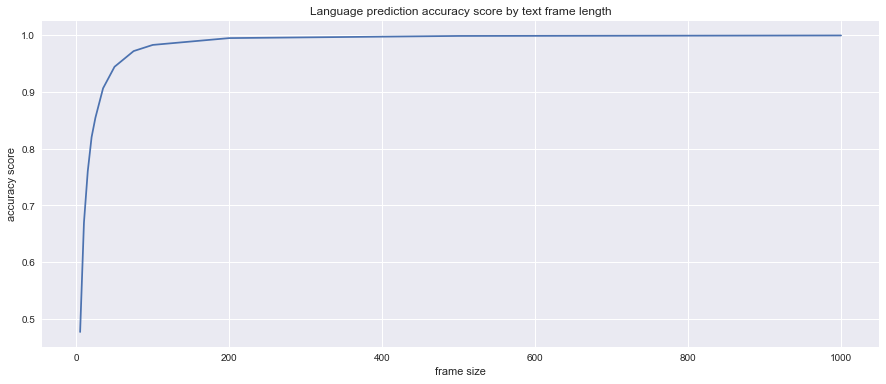

In [267]:
print_scores(frame_lenghts, scores)

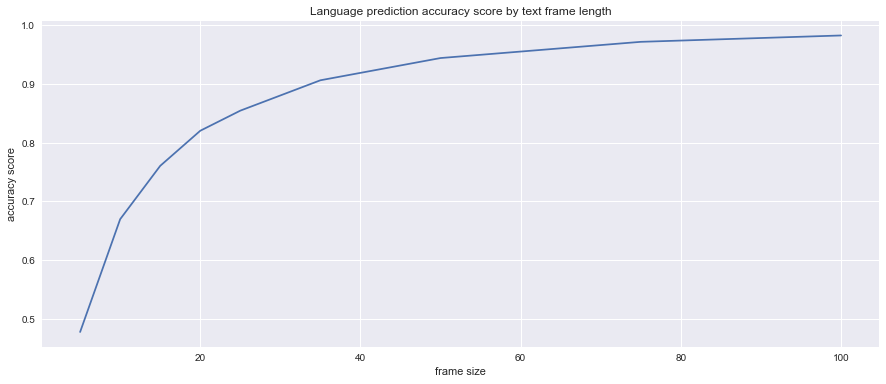

In [268]:
print_scores(frame_lenghts[:-3], scores[:-3])

In [180]:
print 'len\t\tscore\n'
for k, v in zip(frame_lenghts, scores):
    print k, '\t\t', v

len		score

5 		0.477511111111
10 		0.6696
15 		0.760444444444
20 		0.820222222222
25 		0.854444444444
35 		0.906177777778
50 		0.944044444444
75 		0.971644444444
100 		0.982488888889
200 		0.994488888889
500 		0.998266666667
1000 		0.999111111111


Перейдем к наиболее интересной задаче - попробуем различать языки, если бы они были написаны в одном алфавите (латиница). Построим аналогичные графики для этого случая.

### Part II: One latin alphabet 

In [3]:
from textutils import TextProcessor

In [4]:
lang_texts_latin = {}

for lang in languages:
    lang_name = lang[:-8]
    with open('wiki_data/processed/' + lang, 'r') as processed_file:
        text = TextProcessor.get_english_transliteration(
            processed_file.read().replace('\n', '').decode('utf-8')
        )
    lang_texts_latin[lang_name] = text

In [5]:
def generate_english_subsamples (lang_samples_num = 5000, frame_len = 100):

    data = pd.DataFrame(columns=['frame', 'lang'])

    for lang in lang_texts_latin:
        frames = get_text_frames(lang_texts_latin[lang], lang_samples_num, frame_len)
        langs = [lang for _ in range(lang_samples_num)]
        data = pd.concat([data, pd.DataFrame({'frame': frames, 'lang': langs})], ignore_index=True)

    return data

In [6]:
frame_lenghts_latin = [5, 10, 15, 20, 25, 35, 50, 75, 100, 200, 300, 500, 750, 1000]
scores_latin = []

In [193]:
print "Done for (frame length): ",
for frame_len in frame_lenghts_latin:
    sample = generate_english_subsamples(frame_len=frame_len)
    sample.lang = encoder.fit_transform(sample.lang)
    x_tr, x_cv, y_tr, y_cv = train_test_split(sample.frame, sample.lang, test_size = 0.3)
    ngram_tr = ngram_vectorizer.fit_transform(x_tr)
    ngram_te = ngram_vectorizer.transform(x_cv)
    ovr.fit(ngram_tr, y_tr)
    preds_sample = ovr.predict(ngram_te)
    scores_latin.append(accuracy_score(y_cv, preds_sample))
    print frame_len,

Done for (frame length):  5 10 15 20 25 35 50 75 100 200 300 500 750 1000


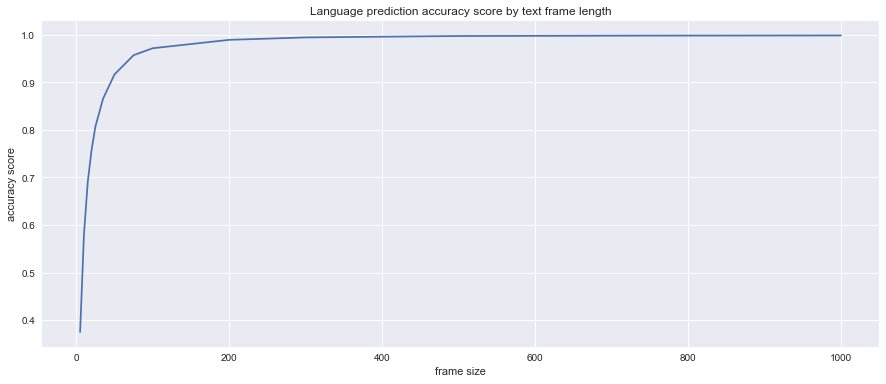

In [269]:
print_scores(frame_lenghts_latin, scores_latin)

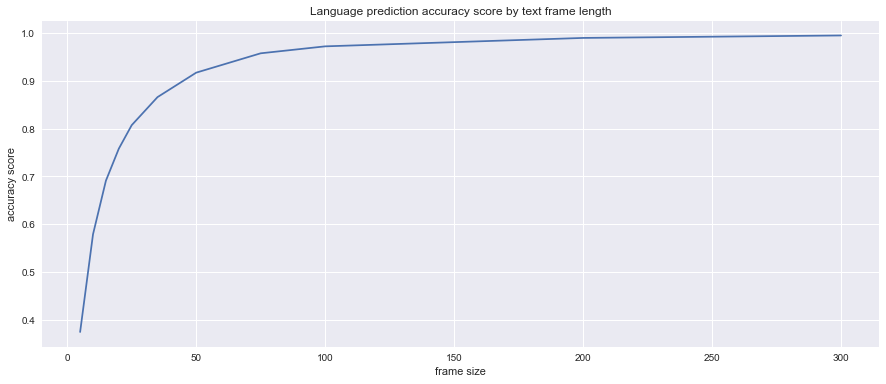

In [270]:
print_scores(frame_lenghts_latin[:-3], scores_latin[:-3])

In [200]:
print 'len\t\tscore\t\t\tscore latin\n'
for k, v1, v2 in zip(frame_lenghts, scores, scores_latin):
    print k, '\t\t', v1, '\t\t', v2

len		score			score latin

5 		0.477511111111 		0.374888888889
10 		0.6696 		0.579111111111
15 		0.760444444444 		0.691155555556
20 		0.820222222222 		0.758044444444
25 		0.854444444444 		0.8072
35 		0.906177777778 		0.865822222222
50 		0.944044444444 		0.916977777778
75 		0.971644444444 		0.957422222222
100 		0.982488888889 		0.971955555556
200 		0.994488888889 		0.989555555556
500 		0.998266666667 		0.994711111111
1000 		0.999111111111 		0.997644444444


### Select K-Best 

Возьмем в качестве образца фреймы длины 100, на выборке с текстами в исходном алфавите качество определения языка для такой длины текстов составляет `0.982`, для текстов в едином алфавите (в латинице) - чуть хуже, `0.971`. Наибольший интерес относительно Манускрипта Войнича составляет выборка текстов в едином алфавите. Количество различных N-грам при этом равно ~125k. 
Интересно проверить, какие именно N-граммы содержат в себе максимум информации о том или ином языке. Попробуем для этого воспользоваться методом K-Best, который позволяет оставить из всей выборки только нужное число признаков, сохраняя максимальную энтропию системы. Проверим также зависимость числа признаков от качества определения языка.

Генерируем выборку и перекодируем целевой категориальный признак (language) в целочисленный формат

In [133]:
frame_len = 100
sample = generate_english_subsamples(frame_len=frame_len)
sample.lang = encoder.fit_transform(sample.lang)

Векторизуем данные с помощью N-грам. Формат на выходе - разреженная матрица, количество признаков `~125k`

In [134]:
x_tr, x_cv, y_tr, y_cv = train_test_split(sample.frame, sample.lang, test_size = 0.3, random_state = 42)
ngram_tr = ngram_vectorizer.fit_transform(x_tr)
ngram_te = ngram_vectorizer.transform(x_cv)

In [135]:
ngram_tr.shape

(52500, 125789)

Воспользуемся K-Best, для нормальной работы с sparse matricies в задаче классификации рекомендуется использовать критерии `chi2`, или `mutual_info_classif`, хотя со вторым модель работает крайне медленно.

In [136]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

Построим зависимость качества предсказания языка от количества лучших выбранных признаков (N-грам)

In [137]:
k_s = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 125000]
scores_k = []

print 'k-best\t\tscore\n'
for k in k_s:
    skb = SelectKBest(chi2, k=k)
    x_tr_kbest = skb.fit_transform(ngram_tr, y_tr)
    x_cv_kbest = skb.transform(ngram_te)
    ovr.fit(x_tr_kbest, y_tr)
    preds_kbest = ovr.predict(x_cv_kbest)
    scores_k.append(accuracy_score(y_cv, preds_kbest))
    print k, '\t\t', scores_k[-1]

k-best		score

10 		0.258577777778
25 		0.380888888889
50 		0.438577777778
100 		0.48
250 		0.711911111111
500 		0.814977777778
1000 		0.884977777778
2500 		0.933866666667
5000 		0.949866666667
10000 		0.962711111111
25000 		0.969022222222
50000 		0.970577777778
100000 		0.971111111111
125000 		0.9712


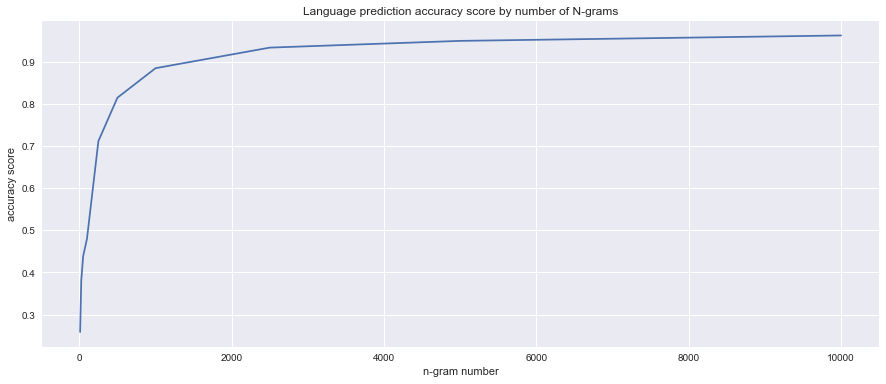

In [138]:
print_k_best_scores(k_s[:-4], scores_k[:-4])

Посмотрим глазами на эти N-граммы. Отобразим первые K тех, которые считались "лучшими". Посмотрим также, какие именно языки эти N-грамы описывают лучше всего.

In [ ]:
from sklearn import preprocessing

frames_grouped_by_lang = sample.groupby(by='lang', as_index=False).frame.sum()
ngram_grouped = ngram_vectorizer.transform(frames_grouped_by_lang.frame)

feature_scores = sorted (
    zip([i for i in range(len(skb.scores_))], skb.scores_),
    key=lambda x: x[1],
    reverse=True
)

In [236]:
def get_ngram_lang(n_gram):
    data_col_idx = ngram_vectorizer.vocabulary_[n_gram]
    lang_ngram_counts = ngram_grouped.getcol(data_col_idx).data
    if len(lang_ngram_counts) > 2:
        ngram_counts_scaled = preprocessing.scale(lang_ngram_counts)
    else:
        ngram_counts_scaled = lang_ngram_counts
    lang_label_max = np.argmax(np.abs(ngram_counts_scaled))
    return encoder.classes_[lang_label_max]

def print_k_best(k = 10):
    print 'N-gram\t\tLanguage\t\tScore\n'
    for _k in range(k):
        feature_name = ngram_vectorizer.get_feature_names()[feature_scores[_k][0]]
        feature_score = feature_scores[_k][1]
        feature_lang = get_ngram_lang(feature_name)
        print feature_name, '\t\t', feature_lang, '\t\t', feature_score

In [95]:
print_k_best(k=20)

N-gram		Language		Score

sch 		german 		38836.3506431
lctr 		romanian 		31061.0611967
dll 		italian 		29764.4322272
ctr 		romanian 		22379.2642959
tncm 		romanian 		22204.5065305
lct 		romanian 		21856.7788511
wrd 		croatian 		21119.9679127
czn 		italian 		20371.5284929
tnc 		romanian 		18659.4226004
ths 		english 		18110.8786345
thr 		english 		17775.9516444
tht 		english 		17708.1793179
blgr 		romanian 		17673.5824438
wdz 		danish 		17409.8626416
chn 		german 		16908.6401484
scw 		dutch 		16859.263593
prz 		polish 		16352.9702822
fth 		english 		15880.6260587
pntr 		romanian 		15404.2819856
rlr 		romanian 		14968.5369053


### Part III: European languages groups classification

Отойдем от задачи классификации европейских языков на 15 классов и попробуем рассмотреть классификацию языков на языковые группы, их всего 5: 
1. славянская группа, западная подгруппа: польский, чешский;
2. славянская группа, южная подгруппа: сербский, хорватский, болгарский;
3. германская группа, северная подгруппа: датский, шведский, норвежский; 
4. германская группа, западная подгруппа: немецкий, английский, голландский;
5. романская группа: итальянский, испанский, французский, румынский.

Такой подход предположительно позволит классифицировать тексты с большей точностью, а также уменьшить количество "решающих" N-грам, максимально описывающих ту или иную группу (подгруппу).

In [98]:
lang_groups = {
    'swedish': 'ger_north',
    'danish': 'ger_north',
    'bulgarian': 'slav_south',
    'norwegian': 'ger_north',
    'czech': 'slav_west',
    'romanian': 'romance',
    'english': 'ger_west',
    'french': 'romance',
    'spanish': 'romance',
    'german': 'ger_west',
    'serbian': 'slav_south',
    'dutch': 'ger_west',
    'polish': 'slav_west',
    'italian': 'romance',
    'croatian': 'slav_south'
}

Аналогично предыдущим пунктам, рассмотрим зависимость 5-ти классовой классификации текстов от длины их фрагментов и количества "лучших" признаков (N-грам)

In [107]:
frame_lenghts_groups = [5, 10, 15, 20, 25, 35, 50, 75, 90, 100]
scores_groups = []

print 'length\t\tscore\n'
for frame_len in frame_lenghts_groups:
    sample = generate_english_subsamples(frame_len=frame_len)
    sample['lang_group'] = sample.lang.apply(lambda x: lang_groups[x])
    sample.lang_group = encoder.fit_transform(sample.lang_group)

    x_tr, x_cv, y_tr, y_cv = train_test_split(sample.frame, sample.lang_group, test_size = 0.3, random_state = 42)
    ngram_tr = ngram_vectorizer.fit_transform(x_tr)
    ngram_te = ngram_vectorizer.transform(x_cv)

    ovr.fit(ngram_tr, y_tr)
    preds_sample = ovr.predict(ngram_te)
    scores_groups.append(accuracy_score(y_cv, preds_sample))
    print frame_len, '\t\t', scores_groups[-1]

length		score

5 		0.5708
10 		0.740666666667
15 		0.825511111111
20 		0.8696
25 		0.904266666667
35 		0.939066666667
50 		0.9664
75 		0.985422222222
90 		0.9888
100 		0.990311111111


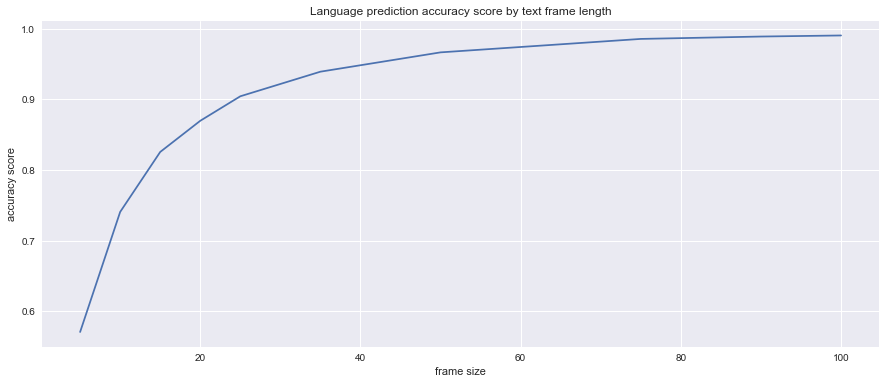

In [109]:
print_scores(frame_lenghts_groups, scores_groups)

Как мы уже видим из полученных результатов, языковая группа на тех же данных предсказывается гораздо точнее, чем сам язык. Посмотрим теперь на K-best признаков.

In [111]:
k_s = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 125000]
scores_k = []

print 'k-best\t\tscore\n'
for k in k_s:
    skb = SelectKBest(chi2, k=k)
    x_tr_kbest = skb.fit_transform(ngram_tr, y_tr)
    x_cv_kbest = skb.transform(ngram_te)
    ovr.fit(x_tr_kbest, y_tr)
    preds_kbest = ovr.predict(x_cv_kbest)
    scores_k.append(accuracy_score(y_cv, preds_kbest))
    print k, '\t\t', scores_k[-1]

k-best		score

10 		0.566577777778
25 		0.684177777778
50 		0.7524
100 		0.843644444444
250 		0.9192
500 		0.943822222222
1000 		0.964222222222
2500 		0.980088888889
5000 		0.985555555556
10000 		0.9892
25000 		0.989911111111
50000 		0.990444444444
100000 		0.9904
125000 		0.990355555556


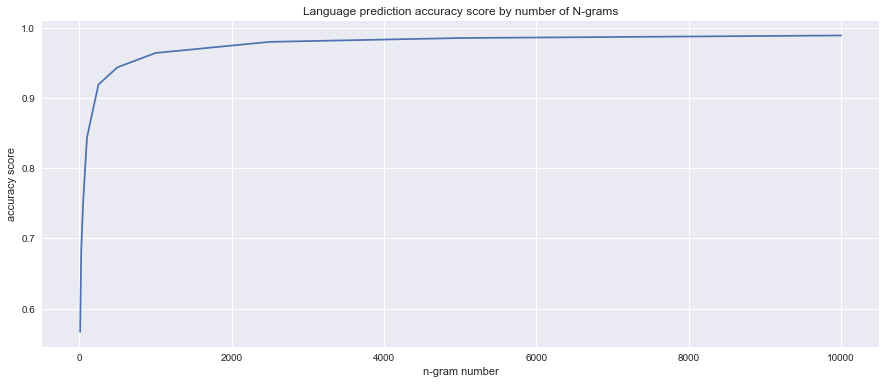

In [132]:
print_k_best_scores(k_s[:-4], scores_k[:-4])

Становится ясно, что для предсказания языковой группы требуется гораздо меньшее количество ключевых N-грам, более того, начиная с какого-то момента (примерно 40-50к признаков), увеличение количества признаков только ухудшает качество предсказания. Посмотрим, что из себя представляют те же 10-Best

In [114]:
from sklearn import preprocessing

frames_grouped = sample.groupby(by='lang_group', as_index=False).frame.sum()
ngram_grouped = ngram_vectorizer.transform(frames_grouped.frame)

feature_scores = sorted (
    zip([i for i in range(len(skb.scores_))], skb.scores_),
    key=lambda x: x[1],
    reverse=True
)

In [119]:
print_k_best(k=20)

N-gram		Language		Score

sch 		ger_west 		20655.4861301
wrd 		ger_west 		14026.6901693
stv 		slav_south 		11197.7414527
czn 		slav_west 		9875.14037131
prz 		slav_west 		9572.9343798
cht 		ger_west 		8820.26212394
tht 		ger_west 		8699.20107348
mnt 		romance 		8355.97114335
wdz 		ger_north 		8136.97184791
dll 		romance 		8013.73313746
nsk 		ger_north 		7985.3174269
scw 		slav_south 		7870.21843469
ctr 		romance 		7655.81812553
cns 		romance 		7443.60093661
ndr 		ger_west 		7309.10401014
cws 		slav_south 		6913.1419172
chn 		ger_west 		6811.90270058
lct 		romance 		6741.5267859
lctr 		romance 		6570.02475115
wsk 		slav_south 		6558.77042516


### Part IV: Two languages classification 

Отдельно хочется рассмотреть бинарную классификацию текстов, дабы понять, насколько легко между собой различаются два отдельно взятых языка из разных языковых групп, например испанский и английский.

In [239]:
def generate_eng_esp_subsamples (lang_samples_num = 5000, frame_len = 100):
    data = pd.DataFrame(columns=['frame', 'lang'])
    for lang in lang_texts_latin:
        if lang == 'english' or lang == 'spanish':
            frames = get_text_frames(lang_texts_latin[lang], lang_samples_num, frame_len)
            langs = [lang for _ in range(lang_samples_num)]
            data = pd.concat([data, pd.DataFrame({'frame': frames, 'lang': langs})], ignore_index=True)
    return data

In [240]:
frames_eng_esp = [5, 10, 15, 20, 25, 35, 50, 75, 90, 100]
scores_eng_esp = []

print 'length\t\tscore\n'
for frame_len in frames_eng_esp:
    eng_esp = generate_eng_esp_subsamples(lang_samples_num=25000, frame_len=frame_len)
    eng_esp.lang = encoder.fit_transform(eng_esp.lang)

    x_tr, x_cv, y_tr, y_cv = train_test_split(eng_esp.frame, eng_esp.lang, test_size = 0.3, random_state = 42)
    ngram_tr = ngram_vectorizer.fit_transform(x_tr)
    ngram_te = ngram_vectorizer.transform(x_cv)

    lr.fit(ngram_tr, y_tr)
    preds_eng_esp = lr.predict(ngram_te)
    scores_eng_esp.append(accuracy_score(y_cv, preds_eng_esp))
    print frame_len, '\t\t', scores_eng_esp[-1]

length		score

5 		0.784333333333
10 		0.875266666667
15 		0.9286
20 		0.9492
25 		0.965866666667
35 		0.981133333333
50 		0.9894
75 		0.993866666667
90 		0.9962
100 		0.9974


Для двух языков суммарное количество N-грам выходит чуть меньшим, 100к. По таблице качества классификации видно, что для того, чтобы научить модель, которая разделяет два языка, необходимы образцы текстов длиной 25 символов. Это в 4 раза меньше, чем если бы с таким же качеством модель отличала все 15 языков.

In [241]:
ngram_tr.shape

(35000, 99755)

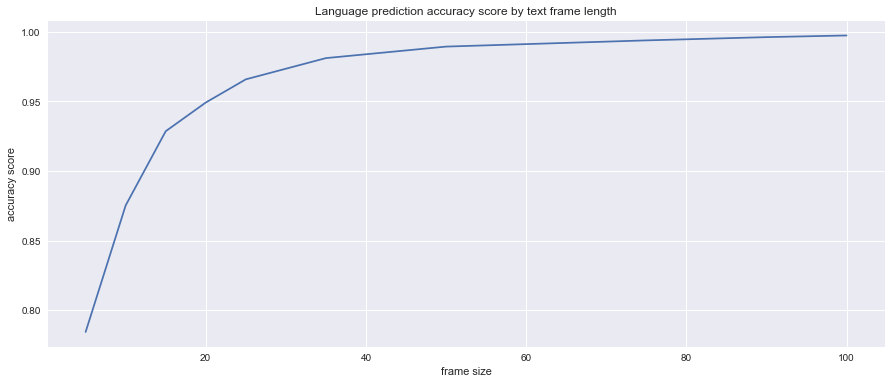

In [242]:
print_scores(frames_eng_esp, scores_eng_esp)

In [243]:
k_s = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000, 90000]
scores_k = []

print 'k-best\t\tscore\n'
for k in k_s:
    skb = SelectKBest(chi2, k=k)
    x_tr_kbest = skb.fit_transform(ngram_tr, y_tr)
    x_cv_kbest = skb.transform(ngram_te)
    lr.fit(x_tr_kbest, y_tr)
    preds_kbest = lr.predict(x_cv_kbest)
    scores_k.append(accuracy_score(y_cv, preds_kbest))
    print k, '\t\t', scores_k[-1]

k-best		score

10 		0.928533333333
25 		0.956266666667
50 		0.9714
100 		0.979066666667
250 		0.987266666667
500 		0.991466666667
1000 		0.993733333333
2500 		0.996266666667
5000 		0.996866666667
10000 		0.997
25000 		0.997333333333
50000 		0.997333333333
90000 		0.997266666667


Видим очень интересный результат - всего 10 ключевых N-грам хватает, чтбы отличить английский язык от испанского с вероятностью `~93%` и 500 N-грам, чтобы точность различимости составляла `~99%` (полная выборка - 99755 Н-грам). Конечно же, интересно посмотреть, какие именно это N-граммы.

In [244]:
frames_grouped = eng_esp.groupby(by='lang', as_index=False).frame.sum()
ngram_grouped = ngram_vectorizer.transform(frames_grouped.frame)

feature_scores = sorted (
    zip([i for i in range(len(skb.scores_))], skb.scores_),
    key=lambda x: x[1],
    reverse=True
)

In [245]:
print_k_best(k=15)

N-gram		Language		Score

thr 		english 		11143.3025056
ths 		english 		9597.38490402
nth 		english 		9449.68583145
tht 		english 		9322.45583043
sth 		english 		8307.38498373
tth 		english 		8044.39927814
fth 		english 		7824.35702636
dth 		english 		7029.45248555
thn 		english 		6795.64419054
rth 		english 		6320.44407975
dls 		spanish 		6079.67157237
sdl 		spanish 		6066.4895097
cnl 		spanish 		5102.84201377
wth 		english 		4987.57941146
thc 		english 		4765.73928705


Интересным тут несомненно является то, что почти все ключевые N-грамы - это те, что присутствуют исключительно в английских текстах. Именно они помогают достаточно верно отделить английский язык от испанского